In [2]:
import numpy as np
import matplotlib.pyplot as plt
import import_ipynb
import pandas as pd
import bioread
import datetime
from Estimaciondeunafdp_new1 import pdf_new1
from Sum_of_square_error_SSE import sse
from Overlapping_Index import area
from Calculo_de_la_cdf_a_partir_de_la_pdf_Version1 import cdf
from Area_bajo_la_curva_ROC import AUC
from scipy.stats import norm, cauchy, gamma, logistic
from fitter import Fitter
from scipy.stats import wasserstein_distance

importing Jupyter notebook from Estimaciondeunafdp_new1.ipynb
importing Jupyter notebook from Sum_of_square_error_SSE.ipynb
importing Jupyter notebook from Overlapping_Index.ipynb
importing Jupyter notebook from Calculo_de_la_cdf_a_partir_de_la_pdf_Version1.ipynb
importing Jupyter notebook from Area_bajo_la_curva_ROC.ipynb


### Enunciado:
La señal del archivo EMG.acq, muestreada a 2kHz, corresponde a un registro de EMG durante un movimiento de abducción-aducción durante un poco más de 30s. Con segmentos de 700 ms de longitud: (a) construye 5 pdf elegidas aleatoriamente y compara una de ellas con el mejor ajuste de las 4 distribuciones continuas paramétricas: normal, de cauchy, logística y gamma. Emplea como criterio de comparación el valor de la suma de los cuadrados de los desvíos. Determina el valor óptimo de los parámetros de la distribución continua de comparación. (b) compara 3 de las 5 pdf entre si empleando al menos dos de las métricas estudiadas. Indica el criterio que utilizas para decidir si la señal es estacionaria con segmentos de700 ms.

In [8]:
data = bioread.read_file('EMG.acq')

In [3]:
data.channels

[Channel EMG (30 - 500 Hz): 62489 samples, 2000.0 samples/sec, loaded: True]

In [9]:
Fs = 2000
emg = data.channels[0].data
nEMG = np.arange(len(emg))
t = nEMG/Fs

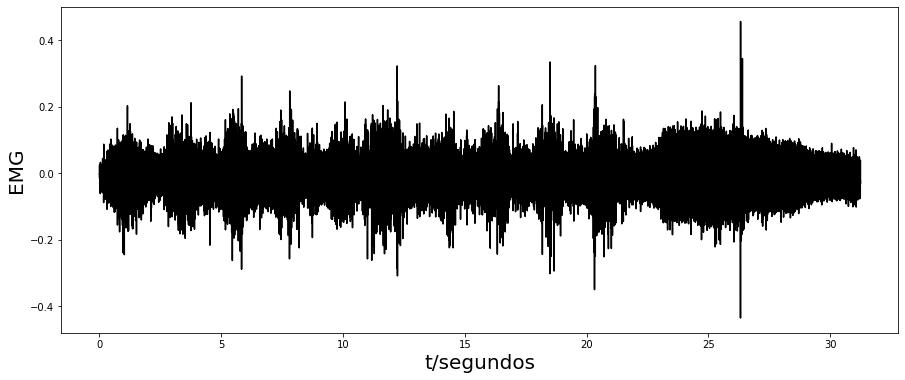

In [5]:
plt.figure(figsize=(15,6))
plt.plot(t,emg,'k')
plt.xlabel('t/segundos',fontsize=20)
plt.ylabel('EMG',fontsize=20)
plt.show()

In [10]:
emg_norm = (emg - np.mean(emg))/np.std(emg)

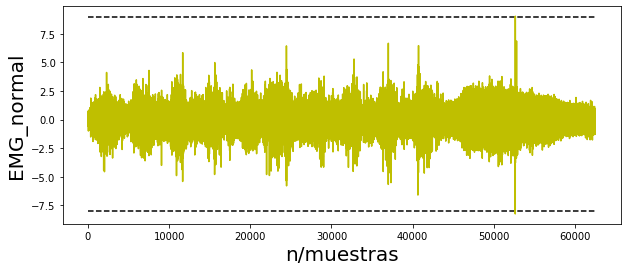

In [7]:
s = np.arange(len(emg_norm))
ylim = np.array([-8,9])
plt.figure(figsize=(10,4))
plt.plot(s,emg_norm,'y')
plt.hlines(ylim,0,len(emg_norm),'k',linestyle='--')
plt.xlabel('n/muestras',fontsize=20)
plt.ylabel('EMG_normal',fontsize=20)
plt.show()

In [8]:
segm = 0.7 * Fs
m = len(emg_norm)//segm
segm, m

(1400.0, 44.0)

In [9]:
tini = datetime.datetime.now()
bigY = np.empty(0,dtype=float); dat = emg_norm; Ndat = len(dat)
x0, xf, Np = -8, 9, 17000; d = (xf-x0)/Np; x = x0 + d * np.arange(Np)
rows = int(segm); col = int(Ndat//segm)
datos = np.reshape(dat[0:rows*col],(rows,col),order='F') #creo una Matriz donde guardo los datos
r = np.random.choice(rows,5,replace=False)# elijo 5 filas al azar
p = datos[r,:]
y1 = pdf_new1(p[0,:],x0,xf,Np,1); y2 = pdf_new1(p[1,:],x0,xf,Np,1)
y3 = pdf_new1(p[2,:],x0,xf,Np,1); y4 = pdf_new1(p[3,:],x0,xf,Np,1)
y5 = pdf_new1(p[4,:],x0,xf,Np,1)
Y = np.hstack((y1,y2,y3,y4,y5))
bigY = np.append(bigY,Y)
tend = datetime.datetime.now()

In [10]:
tend-tini, Np

(datetime.timedelta(microseconds=46874), 17000)

In [11]:
y = np.reshape(Y,(Np,5),order='F')

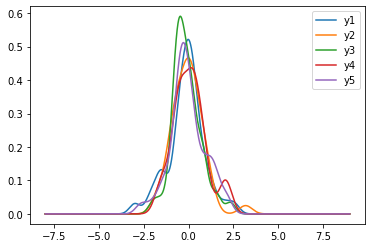

In [12]:
plt.plot(x,y)
plt.legend(('y1','y2','y3','y4','y5',))
plt.show()

### pdf: y5

,sumsquare_error,aic,bic,kl_div
cauchy,8.282655,448.055035,-65.912768,inf
logistic,8.641494,399.970832,-64.046645,inf
gamma,8.846855,390.196443,-59.229048,inf
norm,8.850993,388.006917,-62.992658,inf


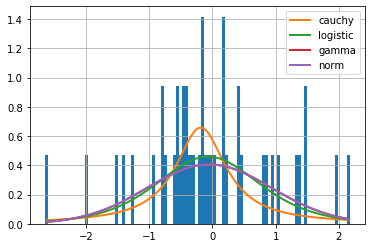

In [13]:
distribuciones = ['norm','cauchy','gamma','logistic']
fitter = Fitter(p[4,:], distributions=distribuciones)
fitter.fit()
fitter.summary(Nbest=4, plot=True)

In [14]:
fitter.fitted_param["logistic"]

(-0.06993994962767763, 0.5444388250979979)

In [15]:
x_logistic = x; 
y_logistic = logistic.pdf(x_logistic, 0.16707212701175014, 0.5848493467588116)

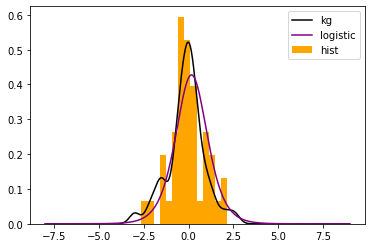

In [16]:
plt.plot(x,y1,'k')
plt. plot(x_logistic,y_logistic,'purple')
plt.hist(p[4,:],bins=14,density=True,color='orange')
plt.legend(('kg','logistic','hist'))
plt.show()

In [17]:
H = np.histogram(p[4,:],bins=14,density=True)
yH = H[0]; xH = H[1][:-1]

In [18]:
sse_kg = sse(xH,yH,x,y1)
sse_kg

0.20341709581343967

In [19]:
sse_cauchy = sse(xH,yH,x_logistic,y_logistic)
sse_cauchy

0.2681283940286425

### Comparación entre las 3 primeras pdf empleando el método del índice de solapamiento

In [20]:
Area_700ms = np.empty(0)
for i in range(0,3):
    for j in range(i+1,3):
        Area_700ms = np.append(Area_700ms, area(x,y[:,i],y[:,j]))

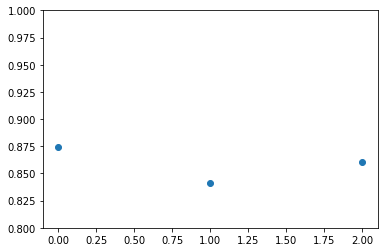

In [21]:
plt.plot(Area_700ms,'o')
plt.ylim(0.8,1)
plt.show()

### Comparación entre pdf empleando la distancia de wasserstein (movimiento de tierra)
Cálculo de la cdf (función de distribución acumulada) a partir de la pdf

In [22]:
cdf1 = cdf(x,y1)
cdf2 = cdf(x,y2)
cdf3 = cdf(x,y3)

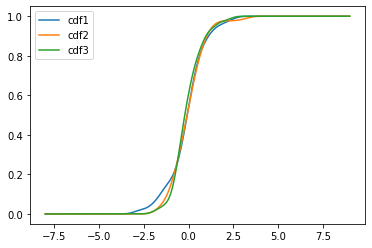

In [23]:
plt.plot(x,cdf1)
plt.plot(x,cdf2)
plt.plot(x,cdf3)
plt.legend(('cdf1','cdf2','cdf3'))
plt.show()

In [24]:
wd = np.empty(0)
for i in range(0,3):
    for j in range(i+1,3):
        wd = np.append(wd, wasserstein_distance(y[:,i],y[:,j],cdf(x,y[:,i]),cdf(x,y[:,j])))

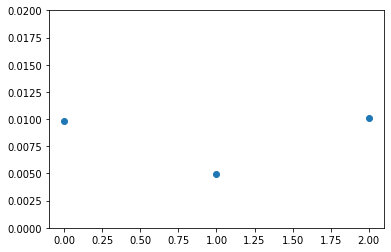

In [46]:
plt.plot(wd,'o')
plt.ylim(0,0.02)
plt.show()

### Comparación entre pdf empleando las curvas ROC

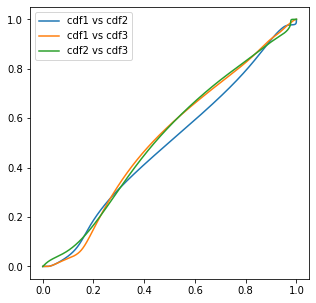

In [26]:
plt.figure(figsize=(5,5))
plt.plot(cdf1,cdf2,)
plt.plot(cdf1,cdf3)
plt.plot(cdf2,cdf3)
plt.legend(('cdf1 vs cdf2','cdf1 vs cdf3','cdf2 vs cdf3'))
plt.show()

Contra más similares sean las distribuciones, más próximo a 1/2 será el área bajo la curva ROC

In [40]:
AUC12 = AUC(cdf1,cdf2); AUC13 = AUC(cdf1,cdf3); AUC23 = AUC(cdf2,cdf3)
AUC12, AUC13, AUC23

(0.5063489457421222, 0.4808582400574175, 0.4779259545021255)

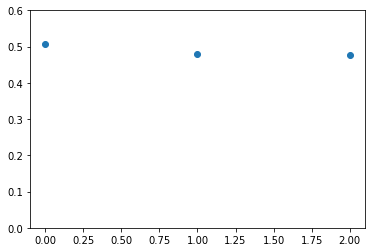

In [48]:
plt.plot(np.array([AUC12, AUC13, AUC23]),'o')
plt.ylim(0,0.6)
plt.show()